In [1]:
print("Python běží!")

Python běží!


In [2]:
import sys

sys.path.append('../')
sys.path.append('../my_libs/')
sys.path.append('../my_libs/img/')

!{sys.executable} -m pip install -r ../../pip-dependencies.txt

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import my_libs as ml
from my_libs.tools import *
from my_libs.fft import *
from my_libs.colors import *
from my_libs.img.processing import *

In [4]:
ml.tools.printf("Hello world!")

Hello world!

# Cvičení 6
1) Načtěte obrázek `pvi_cv06_mince.jpg`. Obraz převeďte do složky Hue. Na 
základě  histogramu  stanovte  práh  a  obraz  segmentujte.  V  jednom  okně 
zobrazte RGB a Hue obraz, histogram a výsledný segmentovaný obraz. 
 
2)  Na  výsledný  binární  obraz  aplikujte  algoritmus  rozvodí  (watershed). 
Nalezenou  hranici  z  rozvodí  zvětšete  pomocí  dilatace  se  strukturním 
elementem 3x3 a odstraňte z původního segmentovaného obrazu, aby došlo 
k oddělení objektů.  
 
3) Artefakty z oddělení objektů odsraňte při využítí algoritmu barvení oblastí. 
Např.: všechny objekty, které mají méně než 1000 obrazových bodů budou 
odstraněny. 
 
4)  Z  binárního  obrazu  vytvořte  granulometrické  spektrum.  Spektrum 
analyzujte  (např.  od  objektů  velikosti  40x40  obrazových  bodů).  Všechny 
poměry menší než 0,9 zanedbejte. Zaokrouhlení poměru - bez desetiné části.  
 
5)  Výstupem bude velikost objektu a počet objektů. 
 
help:  
- https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html 

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

In [9]:
DEBUG = True

img_name = "pvi_cv06_mince.jpg"

In [10]:
# Read the image and convert it to grayscale
img = cv2.imread(img_name)
assert img is not None, "File: " + Blue + img_name + NC + " could not be read, check with os.path.exists()"
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

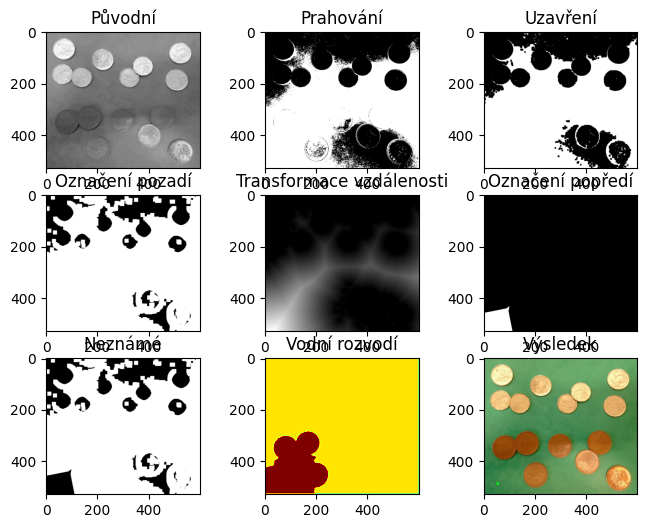

Done.


In [11]:
# Apply thresholding
_, thresh = cv2.threshold(img_gray, 130, 255, 0)

# Invert the thresholded image
thresh = cv2.bitwise_not(thresh)

# Perform morphological operations
kernel = np.ones((6, 6), np.uint8)

# Closing
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
# closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)


# Remove small white regions
sure_bg = cv2.dilate(closing, kernel, iterations=3)

# Distance transform and normalization
dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Subtract the sure foreground from the sure background
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(img, markers)

# Calculate centroids
label_array, num_features = ndimage.label(sure_fg)
centroid_list = ndimage.center_of_mass(sure_fg, label_array, range(1, num_features + 1))

# Draw centroids on the original image
for centroid in centroid_list:
    cv2.circle(img, (int(centroid[1]), int(centroid[0])), 5, (0, 255, 0), -1)

# Display the result

plot_imgs(
    [img_gray, thresh, closing, sure_bg, dist_transform, sure_fg, unknown, markers, img],
    ["Původní", "Prahování", "Uzavření", "Označení pozadí", "Transformace vzdálenosti", "Označení popředí", "Neznámé", "Vodní rozvodí", "Výsledek"],
    rows=3,
    cmaps=["gray", "gray", "gray", "gray", "gray", "gray", "gray", "jet", None],
    window_name="Watershed"
)

print(Green + "Done" + NC)
